In [1]:
!pip install numpy matplotlib pillow torchvision torch tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
!pip install tensorflow numpy matplotlib segmentation-models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.6 MB/s eta 0:00:00


In [3]:
!pip install albumentations opencv-python

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os
from glob import glob
import cv2
import matplotlib.pyplot as plt

In [7]:
# --- Configs ---
IMG_SIZE = 128
#BATCH_SIZE = 4
NUM_CLASSES = 2  # Background, Field
AUG_PER_IMAGE = 6  # number of augmentations per image

image_dir = "/content/drive/MyDrive/Satellite_images/Not_very_cloudy"
mask_dir = "/content/drive/MyDrive/Satellite_images/label_to_mask"

In [7]:
#EPOCHS = 100

In [8]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from glob import glob
import albumentations as A

In [9]:
# --- Augmentation pipeline ---
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
], additional_targets={'mask': 'mask'})

# --- Define load + augment function ---
def load_and_augment(img_path, mask_path, augment_n=5):
    img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img = img_to_array(img).astype(np.uint8)

    mask = load_img(mask_path, target_size=(IMG_SIZE, IMG_SIZE), color_mode='grayscale')
    mask = img_to_array(mask).astype(np.uint8)[..., 0]

    augmented_images, augmented_masks = [], []

    # Include original image
    img_norm = img.astype(np.float32) / 255.0
    mask_onehot = tf.one_hot(mask, NUM_CLASSES)
    augmented_images.append(img_norm)
    augmented_masks.append(mask_onehot)

    # Generate augmentations
    for _ in range(augment_n):
        augmented = augmentation(image=img, mask=mask)
        aug_img = augmented['image'].astype(np.float32) / 255.0
        aug_mask = tf.one_hot(augmented['mask'], NUM_CLASSES)

        augmented_images.append(aug_img)
        augmented_masks.append(aug_mask)

    return augmented_images, augmented_masks


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [10]:
# --- Load and augment dataset ---
image_paths = sorted(glob(os.path.join(image_dir, "*.jpg")))
mask_paths = sorted(glob(os.path.join(mask_dir, "*.png")))

assert len(image_paths) == len(mask_paths), "Mismatch image/mask counts"

all_images, all_masks = [], []

for i_path, m_path in zip(image_paths, mask_paths):
    imgs, msks = load_and_augment(i_path, m_path, augment_n=AUG_PER_IMAGE)
    all_images.extend(imgs)
    all_masks.extend(msks)

images = np.array(all_images)
masks = np.array(all_masks)

print("Augmented dataset shape:")
print("Images:", images.shape)
print("Masks:", masks.shape)

Augmented dataset shape:
Images: (553, 128, 128, 3)
Masks: (553, 128, 128, 2)


In [14]:
images.shape

(553, 128, 128, 3)

In [11]:
from sklearn.model_selection import train_test_split

# Adjust ratio and random state as needed
X_train, X_test, y_train, y_test = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

In [12]:
BATCH_SIZE = 16  # or your preferred batch size

# Training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)) \
    .shuffle(buffer_size=len(X_train)) \
    .batch(BATCH_SIZE) \
    .prefetch(tf.data.AUTOTUNE)

# Testing dataset
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)) \
    .batch(BATCH_SIZE) \
    .prefetch(tf.data.AUTOTUNE)

In [17]:
# data=next(iter(train_dataset))
# data

In [18]:
def build_unet_resnet50(input_shape=(128, 128, 3), num_classes=2):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    skip1 = base_model.get_layer("conv1_relu").output        # 64x64
    skip2 = base_model.get_layer("conv2_block3_out").output  # 32x32
    skip3 = base_model.get_layer("conv3_block4_out").output  # 16x16
    skip4 = base_model.get_layer("conv4_block6_out").output  # 8x8

    x = base_model.output  # 4x4

    def upsample_concat(x, skip, filters):
        x = layers.Conv2DTranspose(filters, 2, strides=2, padding='same')(x)
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        return x

    x = upsample_concat(x, skip4, 512)  # 4->8
    x = upsample_concat(x, skip3, 256)  # 8->16
    x = upsample_concat(x, skip2, 128)  # 16->32
    x = upsample_concat(x, skip1, 64)   # 32->64

    # Add one more upsampling to go 64 -> 128 (final output size)
    x = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(x)  # 64->128
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)

    x = layers.Conv2D(num_classes, 1, padding='same')(x)
    outputs = layers.Activation('softmax')(x)

    model = Model(base_model.input, outputs)
    return model

In [19]:
model=build_unet_resnet50(input_shape=(128, 128, 3), num_classes=2)
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 40,996,706 (156.39 MB)

 Trainable params: 40,943,586 (156.19 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [29]:

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --- Train ---
history=model.fit(train_dataset, validation_data=test_dataset, epochs=50)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 394s 12s/step - accuracy: 0.7112 - loss: 0.5911 - val_accuracy: 0.3598 - val_loss: 1.0936
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 331s 12s/step - accuracy: 0.7349 - loss: 0.5197 - val_accuracy: 0.5003 - val_loss: 0.8704
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 331s 12s/step - accuracy: 0.7672 - loss: 0.4738 - val_accuracy: 0.3603 - val_loss: 1.8317
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 352s 13s/step - accuracy: 0.7965 - loss: 0.4323 - val_accuracy: 0.3865 - val_loss: 8.9136
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 368s 12s/step - accuracy: 0.8004 - loss: 0.4207 - val_accuracy: 0.3740 - val_loss: 2.7852
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 359s 13s/step - accuracy: 0.8186 - loss: 0.3935 - val_accuracy: 0.4130 - val_loss: 7.9885
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 334s 12s/step - accuracy: 0.8366 - loss: 0.3573 - val_accuracy: 0.3843 - val_loss: 1.4234
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 338s 12s/step - accuracy: 0.8492 - loss: 0.3318 - val_accuracy: 0.

In [34]:
model.save('/content/drive/MyDrive/Satellite_images/unet_crop_segmentation.h5')

In [30]:
# Get an iterator from the test dataset
test_iterator = iter(test_dataset)

# Get one batch (a tuple of (images, masks))
image_batch, mask_batch = next(test_iterator)

# image_batch shape: (batch_size, H, W, C)
# mask_batch shape: (batch_size, H, W, NUM_CLASSES)

In [31]:
pred_batch = model.predict(image_batch)  # shape: (batch_size, H, W, NUM_CLASSES)
pred_mask = tf.argmax(pred_batch[0], axis=-1).numpy()  # shape: (H, W)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


In [32]:
import cv2
import numpy as np

# Convert predicted mask (int32) to uint8
mask_uint8 = pred_mask.astype(np.uint8)

# Now find contours
contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

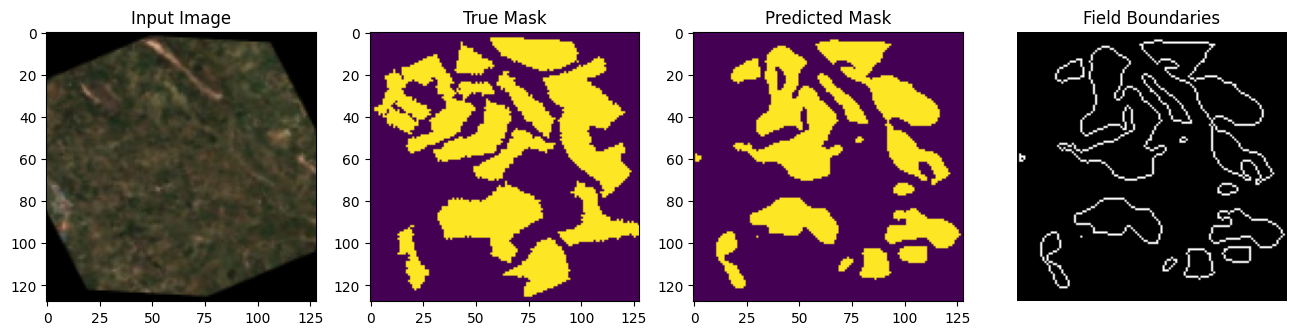

In [33]:
plt.figure(figsize=(16,4))  # a bit wider for 4 plots

plt.subplot(1, 4, 1)
plt.imshow(image_batch[0])
plt.title("Input Image")

plt.subplot(1, 4, 2)
plt.imshow(tf.argmax(mask_batch[0], axis=-1))
plt.title("True Mask")

plt.subplot(1, 4, 3)
plt.imshow(pred_mask)
plt.title("Predicted Mask")

plt.subplot(1, 4, 4)
# Create a blank 2D image of the same shape, type uint8
boundary_img = np.zeros(mask_uint8.shape, dtype=np.uint8)
# Draw contours
cv2.drawContours(boundary_img, contours, -1, color=255, thickness=1)
# Display
plt.imshow(boundary_img, cmap='gray')
plt.title("Field Boundaries")
plt.axis('off')

plt.show()